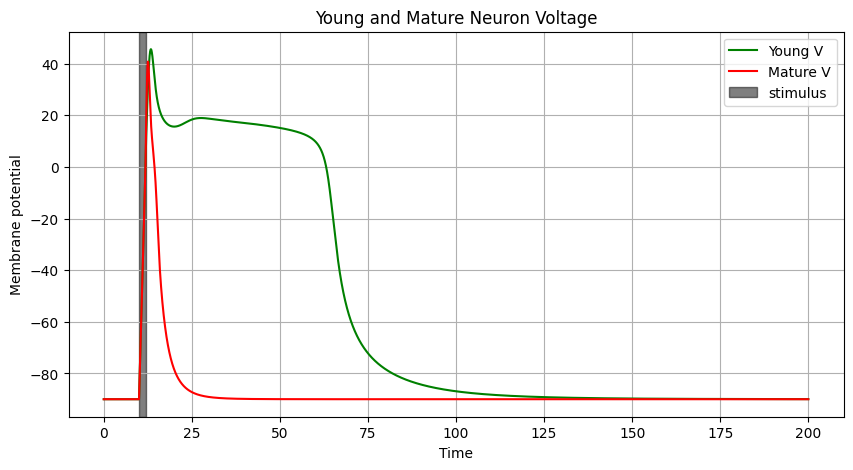

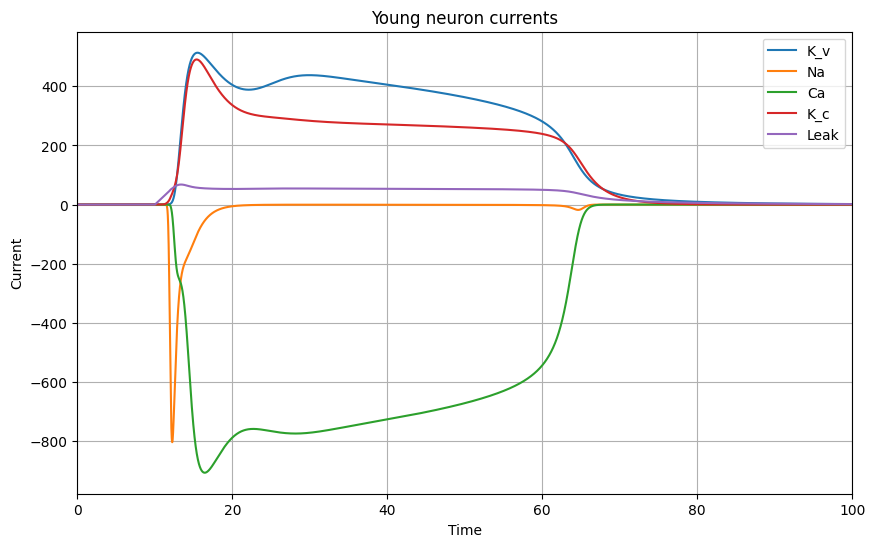

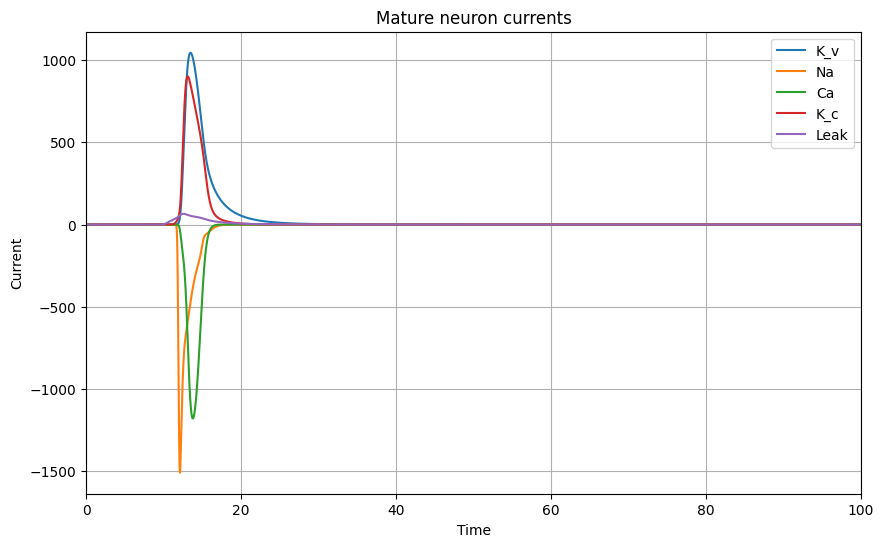

In [3]:
# -----------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt


R_GAS    = 8.314462618      # J/(mol·K)
FARADAY  = 96485.3329       # C/mol
TEMP     = 293.15           # K (20°C)
CA_O     = 4.5e-2  #M
CA_I_REST = 1e-7  # M
CA_R = 1e-7
CA_D = 1
E_K       = -90.0 #mv
E_LEAK    = E_K #mv
C_M      = 18.0 #pico

def ghk_current(v_mV, P, gate, Cai_mM):
    z = 2.0  # Charge for Ca²⁺
    V = v_mV * 1e-3   # Convert mV to Volts

    # Concentration in mol
    Ci = Cai_mM
    Co = CA_O

    # GHK current calculation directly
    arg_exp = (z * FARADAY * V) / (R_GAS * TEMP)
    exp_arg = np.exp(arg_exp)
    num = Ci * exp_arg - Co
    denom = exp_arg - 1.0
    ghk = (z ** 2 * FARADAY ** 2 * V / (R_GAS * TEMP)) * (num / denom)
    I_Amps = P * gate * ghk
    return I_Amps

def I_inj(t):
    return 900.0 if 10 < t < 12 else 0.0  # pA

#  Ca‐dependent gating

def j_inf(v, Cai, theta, sigma):
    return 1.0 / (1.0 + np.exp(2*(theta(v) - Cai)/sigma(v)))

def theta_kcs_y(v): return 1e-7
def sigma_kcs_y(v): return 1e-13
def theta_kci_y(v): return 1e-7
def sigma_kci_y(v): return 1e-13

def theta_kcs_m(v):
    return 1e-7 * (1 + (2.62e7/(1+np.exp((109.72-v)/32.98))**8))
def sigma_kcs_m(v):
    return 10**(0.099*v - 10.27)

def theta_kci_m(v):
    return 1e-7 * (1 + (3.86e7/(1+np.exp((99.56-v)/30.96))**8))
def sigma_kci_m(v):
    return 10**(0.10*v - 11.00)

def r1_kci_y(v):
    return 0.50/(1 + np.exp((16.34 - v)/12.42))
def r1_kci_m(v):
    return 0.55/(1 + np.exp(-(4.88 + v)/12.29))

#  MODEL DERIVATIVES

def model_derivatives(v, mkv, mna, hna, mca, hca,mkcs, mkci, B, S1, S2, Cai, t, age):

    # parameter sets for 'young' or 'mature'
    if age == 'young':
        # Kv
        f_kv, g_kv, p_kv = 0.41, 19.78, 2
        A_kv = 1/(1+np.exp((23.78-v)/8.80))**0.34
        tau_kv = 470.10/(1+np.exp((v+111.68)/21.39)) + 1.47
        # Na
        f_na, g_na, E_na, p_na = 0.92, 29.62, 75.48, 3
        A_na = 1/(1+np.exp(-(v+15.90)/5.59))
        tau_na = 0.82*(0.80/(1+np.exp((v+14.64)/10.41))+0.20)
        B_na   = 1/(1+np.exp((v+24.50)/5.24))
        tauB_na= 71.06*(0.98/(1+np.exp((v+35.52)/7.03))+0.02)
        # Ca
        f_ca, P_ca, p_ca = 0.85, 0.42, 3
        A_ca = 1/(1+np.exp((4.19-v)/8.21))
        tauA_ca = 1.29*(0.80/(1+np.exp((v-15.00)/10.10))+0.20)
        B_ca = 0.74/(1+np.exp((v-6.45)/9.28)) + 0.26
        tauB_ca= 80.0 + 351.1/(1+np.exp((0.54-v)/16.55))**8.05
        # Kcs
        f_kcs, g_kcs, p_kcs = 0.65, 4.50, 1
        H_kcs    = 1/(1+np.exp(-(v+8.01)/13.84))
        tau_kcs  = 4.50
        th_kcs, sg_kcs = theta_kcs_y, sigma_kcs_y
        # Kci
        f_kci, g_kci, p_kci = 1.38, 15.00, 5
        H_kci    = 1/(1+np.exp((2.71-v)/6.70))
        tau_kci  = 208.59*(0.9936/(1+np.exp((v+48.20)/12.39))+0.0064)
        th_kci, sg_kci = theta_kci_y, sigma_kci_y
        r1fn, r2, r3, r4 = r1_kci_y, 1.5, 0.1, 1e-5

    else:  # mature
        # Kv
        f_kv, g_kv, p_kv = 0.67, 36.41, 3
        A_kv = (1/(1+np.exp((10.95-v)/13.90)))**0.42
        tau_kv = 103.25/(1+np.exp((v+66.72)/13.60)) + 0.87
        # Na
        f_na, g_na, E_na, p_na = 1.91, 24.42, 90.00, 3
        A_na = 1/(1+np.exp(-(v+12.22)/3.87))
        tau_na = 1.36*(0.91/(1+np.exp((v+21.08)/7.91))+0.09)
        B_na   = 1/(1+np.exp((v+24.50)/5.24))
        tauB_na= 2.50*(0.66/(1+np.exp((v+5.66)/10.43))+0.34)
        # Ca
        f_ca, P_ca, p_ca = 0.80, 0.38, 3
        A_ca = 1/(1+np.exp((1.73-v)/7.48))
        tauA_ca = 0.84*(0.80/(1+np.exp((v-20.00)/10.39))+0.20)
        B_ca  = 0.77/(1+np.exp((v+1.32)/1.05)) + 0.23
        tauB_ca= 101.52*(0.31/(1+np.exp((v+0.07)/0.77))+0.69)
        # Kcs
        f_kcs, g_kcs, p_kcs = 0.62, 4.36, 1
        H_kcs    = 1/(1+np.exp(-(v+26.96)/4.79))
        tau_kcs  = 4.00
        th_kcs, sg_kcs = theta_kcs_m, sigma_kcs_m
        # Kci
        f_kci, g_kci, p_kci = 0.56, 40.00, 5
        H_kci    = 1/(1+np.exp(-(v+28.11)/8.25))
        tau_kci  = 1.82*(0.73/(1+np.exp((v-3.28)/10.48))+0.27)
        th_kci, sg_kci = theta_kci_m, sigma_kci_m
        r1fn, r2, r3, r4 = r1_kci_m, 1.5, 0.1, 1e-5

    # Currents
    I_kv   = f_kv*g_kv*mkv**p_kv*(v - E_K)
    I_na   = f_na*g_na*mna**p_na*hna*(v - E_na)
    I_ca   = ghk_current(v, f_ca*P_ca, mca**p_ca*hca, Cai)
    I_kcs  = f_kcs*g_kcs*mkcs**p_kcs*(v - E_K)
    I_kci  = f_kci*g_kci*mkci**p_kci*B*(v - E_K)
    I_leak = 0.5*(v - E_LEAK)
    I_tot  = I_kv + I_na + I_ca + I_kcs + I_kci + I_leak

    # Derivatives
    dV    = -(I_tot - I_inj(t)) / C_M
    dmkv  = (A_kv - mkv)  / tau_kv
    dmna  = (A_na - mna)  / tau_na
    dhna  = (B_na - hna)  / tauB_na
    dmca  = (A_ca - mca)  / tauA_ca
    dhca  = (B_ca - hca)  / tauB_ca
    A_kcs = H_kcs * j_inf(v, Cai, th_kcs, sg_kcs)
    dmkcs = (A_kcs - mkcs)/ tau_kcs
    A_kci = H_kci * j_inf(v, Cai, th_kci, sg_kci)
    dmkci = (A_kci - mkci)/ tau_kci

    r1 = r1fn(v)
    dB  = r3*S1     - r1*B
    dS1 = r1*B + r4*S2 - (r2+r3)*S1
    dS2 = r2*S1     - r4*S2
    dCai = CA_R * (-I_ca) - CA_D*(Cai - 1e-7)

    return (dV, dmkv, dmna, dhna, dmca, dhca, dmkcs, dmkci,
            dB, dS1, dS2, dCai,
            I_kv, I_na, I_ca, I_kcs, I_kci, I_leak)


#  SIMULATION
def simulation(age, tmax=200.0, dt=0.005):
    t = np.arange(0, tmax + dt, dt)

    # state variables
    V    = np.zeros(len(t))
    mkv  = np.zeros(len(t))
    mna  = np.zeros(len(t))
    hna  = np.zeros(len(t))
    mca  = np.zeros(len(t))
    hca  = np.zeros(len(t))
    mkcs = np.zeros(len(t))
    mkci = np.zeros(len(t))
    B    = np.zeros(len(t))
    S1   = np.zeros(len(t))
    S2   = np.zeros(len(t))
    Cai  = np.zeros(len(t))

    # current arrays
    I_kv_arr   = np.zeros(len(t))
    I_na_arr   = np.zeros(len(t))
    I_ca_arr   = np.zeros(len(t))
    I_kcs_arr  = np.zeros(len(t))
    I_kci_arr  = np.zeros(len(t))
    I_leak_arr = np.zeros(len(t))

    # initial conditions
    V[0]   = -90.0 #mv
    B[0]   = 1.0
    S1[0]  = 0.0
    S2[0]  = 0.0
    Cai[0] = CA_I_REST

    if age == 'young':
        mkv[0]  = (1/(1+np.exp((23.78-V[0])/8.80)))**0.34
        mna[0]  = 1/(1+np.exp(-(V[0]+15.90)/5.59))
        hna[0]  = 1/(1+np.exp((V[0]+24.50)/5.24))
        mca[0]  = 1/(1+np.exp((4.19 - V[0])/8.21))
        hca[0]  = 0.74/(1+np.exp((V[0]-6.45)/9.28)) + 0.26
        mkcs[0] = 1/(1+np.exp(-(V[0]+8.01)/13.84)) * j_inf(V[0], CA_I_REST, theta_kcs_y, sigma_kcs_y)
        mkci[0] = 1/(1+np.exp((2.71-V[0])/6.70)) *  j_inf(V[0], CA_I_REST, theta_kci_y, sigma_kci_y)
    else:
        mkv[0]  = (1/(1+np.exp((10.95-V[0])/13.90)))**0.42
        mna[0]  = 1/(1+np.exp(-(V[0]+12.22)/3.87))
        hna[0]  = 1/(1+np.exp((V[0]+24.50)/5.24))
        mca[0]  = 1/(1+np.exp((1.73 - V[0])/7.48))
        hca[0]  = 0.77/(1+np.exp((V[0]+1.32)/1.05)) + 0.23
        mkcs[0] = 1/(1+np.exp(-(V[0]+26.96)/4.79)) * j_inf(V[0], CA_I_REST, theta_kcs_m, sigma_kcs_m)
        mkci[0] = 1/(1+np.exp(-(V[0]+28.11)/8.25)) * j_inf(V[0],CA_I_REST, theta_kci_m, sigma_kci_m)

    # time stepping
    for i in range(1, len(t)):
        (dv, dmkv, dmna, dhna, dmca, dhca, dmkcs, dmkci,
         dB, dS1, dS2, dCai,
         I_kv, I_na, I_ca, I_kcs, I_kci, I_leak
        ) = model_derivatives(
                V[i-1], mkv[i-1], mna[i-1], hna[i-1],
                mca[i-1], hca[i-1], mkcs[i-1], mkci[i-1],
                B[i-1], S1[i-1], S2[i-1], Cai[i-1],
                t[i-1], age
        )

        V[i]    = V[i-1]   + dv   * dt
        mkv[i]  = mkv[i-1] + dmkv * dt
        mna[i]  = mna[i-1] + dmna * dt
        hna[i]  = hna[i-1] + dhna * dt
        mca[i]  = mca[i-1] + dmca * dt
        hca[i]  = hca[i-1] + dhca * dt
        mkcs[i] = mkcs[i-1]+ dmkcs* dt
        mkci[i] = mkci[i-1]+ dmkci* dt
        B[i]    = B[i-1]   + dB   * dt
        S1[i]   = S1[i-1]  + dS1  * dt
        S2[i]   = S2[i-1]  + dS2  * dt
        Cai[i]  = Cai[i-1] + dCai * dt

        I_kv_arr[i]   = I_kv
        I_na_arr[i]   = I_na
        I_ca_arr[i]   = I_ca
        I_kcs_arr[i]  = I_kcs
        I_kci_arr[i]  = I_kci

        I_leak_arr[i] = I_leak

    return (t, V,
            I_kv_arr, I_na_arr, I_ca_arr,
            I_kcs_arr, I_kci_arr, I_leak_arr)

#  RUN & PLOT
t, V_y, Ikv_y, Ina_y, Ica_y, Ikcs_y, Ikci_y, Ileak_y = simulation('young',  tmax=200.0, dt=0.01)
t, V_m, Ikv_m, Ina_m, Ica_m, Ikcs_m, Ikci_m, Ileak_m = simulation('mature', tmax=200.0, dt=0.01)

# voltage comparison
plt.figure(figsize=(10,5))
plt.plot(t, V_y, color='green', label='Young V')
plt.plot(t, V_m, color='red',   label='Mature V')
plt.axvspan(10, 12, color='black', alpha=0.5, label='stimulus')
plt.xlabel('Time')
plt.ylabel('Membrane potential')
plt.title('Young and Mature Neuron Voltage')
plt.legend()
plt.grid(True)
plt.show()

# currents for young neuron
plt.figure(figsize=(10,6))
plt.plot(t, Ikv_y,  label='K_v')
plt.plot(t, Ina_y,  label='Na')
plt.plot(t, Ica_y,  label='Ca')
plt.plot(t, Ikci_y + Ikcs_y, label='K_c')
plt.plot(t, Ileak_y,label='Leak')
plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Young neuron currents')
plt.xlim(0, 100)
plt.legend()
plt.grid(True)
plt.show()

# currents for mature neuron
plt.figure(figsize=(10,6))
plt.plot(t, Ikv_m,  label='K_v')
plt.plot(t, Ina_m,  label='Na')
plt.plot(t, Ica_m,  label='Ca')
plt.plot(t, Ikci_m + Ikcs_m, label='K_c')
plt.plot(t, Ileak_m,label='Leak')
plt.xlabel('Time')
plt.xlim(0, 100)
plt.ylabel('Current')
plt.title('Mature neuron currents')
plt.legend()
plt.grid(True)
plt.show()
